# Temporal SIR

In [1]:
import time
import numpy as np
import torch

from sbi import utils as utils
from sbi import analysis as analysis
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import temporal_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt
import seaborn as sns

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    'font.family' : 'times',
    'font.size' : 14.0,
    'lines.linewidth' : 2,
    'lines.antialiased' : True,
    'axes.facecolor': 'fdfdfd',
    'axes.edgecolor': '777777',
    'axes.linewidth' : 1,
    'axes.titlesize' : 'medium',
    'axes.labelsize' : 'medium',
    'axes.axisbelow' : True,
    'xtick.major.size'     : 0,      # major tick size in points
    'xtick.minor.size'     : 0,      # minor tick size in points
    'xtick.major.pad'      : 6,      # distance to major tick label in points
    'xtick.minor.pad'      : 6,      # distance to the minor tick label in points
    'xtick.color'          : '333333', # color of the tick labels
    'xtick.labelsize'      : 'medium', # fontsize of the tick labels
    'xtick.direction'      : 'in',     # direction: in or out
    'ytick.major.size'     : 0,      # major tick size in points
    'ytick.minor.size'     : 0,      # minor tick size in points
    'ytick.major.pad'      : 6,      # distance to major tick label in points
    'ytick.minor.pad'      : 6,      # distance to the minor tick label in points
    'ytick.color'          : '333333', # color of the tick labels
    'ytick.labelsize'      : 'medium', # fontsize of the tick labels
    'ytick.direction'      : 'in',     # direction: in or out
    'axes.grid' : False,
    'grid.alpha' : 0.3,
    'grid.linewidth' : 1,
    'legend.fancybox' : True,
    'legend.fontsize' : 'Small',
    'figure.figsize' : (2.5, 2.5),
    'figure.facecolor' : '1.0',
    'figure.edgecolor' : '0.5',
    'hatch.linewidth' : 0.1,
    'text.usetex' : False
    })

color_map = {'green': '#009E60', 'orange': '#C04000',
              'blue': '#00416A', 'black':'#3A3B3C',
              'purple': '#843B62', 'red': '#C41E3A'}


plt.rcParams['text.latex.preamble'] = r'\usepackage{serif}'

In [3]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [4]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [5]:
temp_sir = temporal_sir.TemporalSIR()

## data generation

In [ ]:
# DON'T NEED TO RUN
N = 50000

temp_sir_theta_npe_large = temp_sir.sample_theta([N]).reshape(-1, temp_sir.theta_dim)
temp_sir_x_npe_large = torch.empty([N, temp_sir.x_dim])
for i in range(N):
    temp_sir_x_npe_large[i, :] = temp_sir(temp_sir_theta_npe_large[i])

torch.save(temp_sir_x_npe_large, "data/temp_sir_x_npe_large.pt")
torch.save(temp_sir_theta_npe_large, "data/temp_sir_theta_npe_large.pt")

In [94]:
# DON'T NEED TO RUN
temp_sir_obs_theta = torch.tensor([0.5, 0.5])
temp_sir_obs_x = temp_sir(temp_sir_obs_theta)
temp_sir_obs_x

tensor([  16.0000,    4.0000,    4.0000,    7.0000,    5.0000,    7.0000,
           4.0000,   10.0000,    3.0000,   26.0000,   86.0000, 2223.4727])

In [26]:
# DON'T NEED TO RUN
torch.save(temp_sir_obs_x, "data/temp_sir_obs_x.pt")
torch.save(temp_sir_obs_theta, "data/temp_sir_obs_theta.pt")

## Load data

In [27]:
temp_sir_x_npe_large = torch.load("data/temp_sir_x_npe_large.pt")
temp_sir_theta_npe_large = torch.load("data/temp_sir_theta_npe_large.pt")

temp_sir_obs_x = torch.load("data/temp_sir_obs_x.pt")
temp_sir_obs_theta = torch.load("data/temp_sir_obs_theta.pt")

## Fit GP

In [31]:
# for gp
n_train_pair = 500
X = temp_sir_theta_npe_large[:n_train_pair]
n_rep = 20

times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(temp_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = (et - st) / n_rep

In [37]:
# save GP training samples
torch.save(X, "data/temp_sir_gp_x.pt")
torch.save(times_train, "data/temp_sir_gp_y.pt")

In [33]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 200
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')


torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict()
}, 'data/temp_sir_gp.pth')


Iter 1/200 - Loss: 0.754936158657074
Iter 2/200 - Loss: 0.7175566554069519
Iter 3/200 - Loss: 0.6794660091400146
Iter 4/200 - Loss: 0.6406698226928711
Iter 5/200 - Loss: 0.6011747717857361
Iter 6/200 - Loss: 0.5609723925590515
Iter 7/200 - Loss: 0.520072340965271
Iter 8/200 - Loss: 0.47849100828170776
Iter 9/200 - Loss: 0.4362379014492035
Iter 10/200 - Loss: 0.3933223783969879
Iter 11/200 - Loss: 0.3497641086578369
Iter 12/200 - Loss: 0.3055850863456726
Iter 13/200 - Loss: 0.2608034610748291
Iter 14/200 - Loss: 0.21543847024440765
Iter 15/200 - Loss: 0.16951702535152435
Iter 16/200 - Loss: 0.12306603789329529
Iter 17/200 - Loss: 0.07610797137022018
Iter 18/200 - Loss: 0.028669554740190506
Iter 19/200 - Loss: -0.019217833876609802
Iter 20/200 - Loss: -0.06752941757440567
Iter 21/200 - Loss: -0.11623870581388474
Iter 22/200 - Loss: -0.16531427204608917
Iter 23/200 - Loss: -0.21473126113414764
Iter 24/200 - Loss: -0.26446259021759033
Iter 25/200 - Loss: -0.31447893381118774
Iter 26/200 - 

In [34]:
model.eval()
likelihood.eval()

N = 50

beta = torch.linspace(0.1, 1, N)
beta_fixed = 1


gamma_fixed = 0.1
gamma = torch.linspace(0.1, 1, N)

beta_fixed_combined = beta_fixed * torch.ones_like(gamma)
combination_beta_fixed_gamma = torch.stack((beta_fixed_combined, gamma), dim=1)

gamma_fixed_combined = gamma_fixed * torch.ones_like(beta)
combination_beta_gamma_fixed = torch.stack((beta, gamma_fixed_combined), dim=1)

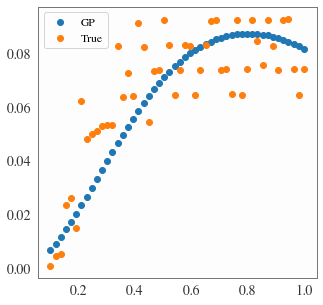

In [35]:
times_vs_beta = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(combination_beta_gamma_fixed[i])
    et = time.time()
    times_vs_beta[i] = (et - st) / n_rep

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_beta_gamma_fixed)).mean

plt.figure(figsize=[5,5])
plt.scatter(beta, observed_pred, label="GP")
plt.scatter(beta, times_vs_beta, label="True")
plt.legend()
plt.show()

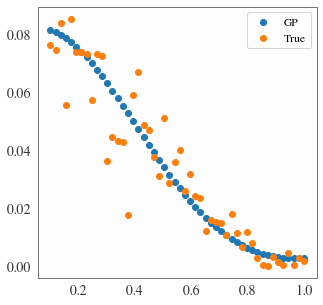

In [36]:
times_vs_gamma = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = temp_sir(combination_beta_fixed_gamma[i])
    et = time.time()
    times_vs_gamma[i] = (et - st) / n_rep

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(combination_beta_fixed_gamma)).mean

plt.figure(figsize=[5,5])
plt.scatter(gamma, observed_pred, label="GP")
plt.scatter(gamma, times_vs_gamma, label="True")
plt.legend()
plt.show()

In [6]:
# Load trained GP
state_dicts = torch.load('data/temp_sir_gp.pth')

X = torch.load("data/temp_sir_gp_x.pt")
times_train = torch.load("data/temp_sir_gp_y.pt")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

<All keys matched successfully>

In [18]:
model.eval()
likelihood.eval()
prior_start = torch.tensor([0.1, 1.0]).reshape(-1, 2)
prior_end = torch.tensor([1.0, 0.1]).reshape(-1, 2)

g_min = likelihood(model(prior_start)).mean
g_max = likelihood(model(prior_end)).mean

print(g_min ** 0.5)
print(g_min ** 1)
print(g_min ** 2)

print(g_max ** 0.5)
print(g_max ** 1)
print(g_max ** 2)

tensor([0.0930], grad_fn=<PowBackward0>)
tensor([0.0087], grad_fn=<PowBackward0>)
tensor([7.4935e-05], grad_fn=<PowBackward0>)
tensor([0.3250], grad_fn=<PowBackward0>)
tensor([0.1056], grad_fn=<PowBackward0>)
tensor([0.0112], grad_fn=<PowBackward0>)


In [8]:
prior_start = torch.tensor([0.1, 1.0]).reshape(-1, 2)
k = 1

num_sim = 5000
theta_tilde = torch.zeros([num_sim, 2])
count = 0
while count < num_sim:
    theta = temp_sir.sample_theta([1]).reshape(-1, 2)
    if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
        theta_tilde[count] = theta.reshape(-1)
        count += 1

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [125]:
w = likelihood(model(theta_tilde)).mean.detach() ** k

In [126]:
theta_prior = temp_sir.sample_theta([5000]).reshape(-1, 2)

In [127]:
plt.hist(theta_prior.detach().numpy()[:, 0], bins=10)
plt.hist(theta_tilde.detach().numpy()[:, 0], bins=10)
plt.show()

In [128]:
likelihood(model(torch.tensor([0.1, 1.0]).reshape(1, 2))).mean

In [129]:
likelihood(model(torch.tensor([0.5, 0.1]).reshape(1, 2))).mean

## CEG ESS

In [23]:
num_sim = 10000
num_repeats = 2
k = np.array([0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]) # Exponent of the penaly function g(z) = z^k

ess_cost_aware = np.zeros([k.size, num_repeats])
ceg = np.zeros([k.size, num_repeats])

for ind in range(k.size):
    for j in range(num_repeats):
        
        if ind == 0:
            theta = temp_sir.sample_theta([num_sim])
            ess_cost_aware[ind, j] = 1
            ceg[ind, j] = 1
        else:
            # Sampling from cost-modified prior
            theta_tilde = torch.zeros([num_sim, 2])
            count = 0
            while count < num_sim:
                param_value = temp_sir.sample_theta([1]).reshape(-1, 2)
                if calc_acc_prob(model, likelihood, param_value, prior_start, k[ind]) > torch.rand(1):
                    theta_tilde[count] = param_value.reshape(-1)
                    count += 1

            w_u = likelihood(model(theta_tilde)).mean.detach() ** k[ind]   #self-normalised importance weights
            
            # Compute CEG
            ceg[ind, j] = torch.mean(likelihood(model(theta)).mean.detach()) / torch.mean(likelihood(model(theta_tilde)).mean.detach())
            # Compute ESS
            ess_cost_aware[ind, j] = ((w_u.sum())**2 / torch.square(w_u).sum()) / num_sim
    print(ind)

In [24]:
ess_cost_aware * ceg

## Train

In [10]:
# DON'T NEED TO RUN
temp_sir_inference_npe_large = SNPE_C()
temp_sir_nn_npe_large = temp_sir_inference_npe_large.append_simulations(
    temp_sir_theta_npe_large, temp_sir_x_npe_large).train()

 Neural network successfully converged after 66 epochs.

In [95]:
# DON'T NEED TO RUN
prior, *_ = process_prior(temp_sir.prior)

temp_sir_post_npe_large = temp_sir_inference_npe_large.build_posterior(temp_sir_nn_npe_large, prior=prior)
temp_sir_post_reference = temp_sir_post_npe_large.sample((1000,), x=temp_sir_obs_x)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
# DON'T NEED TO RUN
torch.save(temp_sir_post_reference, "data/temp_sir_post_reference.pt")

In [16]:
temp_sir_post_reference = torch.load("data/temp_sir_post_reference.pt")

In [ ]:
def get_results(k, n_run):
    mmd_npe = torch.zeros([n_run])
    posterior_samples_npe = torch.zeros([n_run, 1000, 2])
    cost_npe = torch.zeros([n_run])
    mmd_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 2])
    cost_canpe = torch.zeros([n_run])
    
    cost_saved = torch.zeros([n_run])
    
    for i in range(n_run):
        checkpoint_path = f"sims/temp_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
        posterior_npe = checkpoint["posterior_npe"]
        posterior_canpe = checkpoint["posterior_canpe"]
        
    
        # posterior_samples_npe[i] = checkpoint["posterior_samples_npe"]
        # posterior_samples_canpe[i] = checkpoint["posterior_samples_canpe"]
        
        posterior_samples_npe[i] = posterior_npe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=temp_sir_obs_x, show_progress_bars=False)
        
        mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
        mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], temp_sir_post_reference, lengthscale=median_heuristic(temp_sir_post_reference))
        cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
        cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
        
        cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
        
    mmd_npe = mmd_npe.detach().numpy() 
    mmd_npe_mean = np.mean(mmd_npe)
    mmd_npe_std = np.std(mmd_npe)
    
    mmd_canpe = mmd_canpe.detach().numpy() 
    mmd_canpe_mean = np.mean(mmd_canpe)
    mmd_canpe_std = np.std(mmd_canpe)
    
    cost_npe = cost_npe.detach().numpy() 
    cost_npe_mean = np.mean(cost_npe)
    cost_npe_std = np.std(cost_npe)
    
    cost_canpe = cost_canpe.detach().numpy() 
    cost_canpe_mean = np.mean(cost_canpe)
    cost_canpe_std = np.std(cost_canpe)
    
    cost_saved = cost_saved.detach().numpy()
    cost_saved_mean = np.mean(cost_saved)
    cost_saved_std = np.std(cost_saved)
    
    print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")
    print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")
    
    print(f"NPE cost mean {cost_npe_mean:.2f} (std {cost_npe_std:.2f})")
    print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")
    
    print(f"Cost saved: {cost_saved_mean}(std {cost_saved_std})")
    print(mmd_canpe)

In [96]:
get_result('0.5', 50)

NPE MMD mean 0.03 (std 0.03)
CA-NPE MMD mean 0.06 (std 0.03)
NPE cost mean 537.92 (std 65.20)
CA-NPE cost mean 342.77 (std 33.99)
Cost saved: 0.36035996675491333(std 0.03769451379776001)
[0.03182092 0.03682473 0.02605706 0.057053   0.03460255 0.08704913
 0.06508115 0.06027055 0.03891    0.07944262 0.03135851 0.09137711
 0.0457952  0.05041257 0.01924539 0.03255078 0.05547813 0.15267584
 0.10754019 0.10523996 0.08483383 0.05589101 0.03287846 0.03561032
 0.03628561 0.03788319 0.07441524 0.09132782 0.08034819 0.06235808
 0.08549321 0.02677947 0.11148354 0.07350743 0.10017842 0.05264705
 0.01581326 0.036567   0.07452607 0.06063163 0.07532111 0.04308215
 0.02934259 0.04795024 0.05086362 0.02967033 0.1126906  0.02897781
 0.03660518 0.09396246]


In [97]:
get_result('1.0', 50)

NPE MMD mean 0.03 (std 0.03)
CA-NPE MMD mean 0.07 (std 0.03)
NPE cost mean 494.84 (std 96.63)
CA-NPE cost mean 170.36 (std 28.13)
Cost saved: 0.653033971786499(std 0.01951533369719982)


In [98]:
get_result('2.0', 50)

NPE MMD mean 0.03 (std 0.02)
CA-NPE MMD mean 0.07 (std 0.04)
NPE cost mean 446.10 (std 119.01)
CA-NPE cost mean 65.36 (std 13.42)
Cost saved: 0.8509341478347778(std 0.012751813046634197)


In [99]:
get_result('mixture', 50)

CA-NPE MMD mean 0.05 (std 0.04)
CA-NPE cost mean 241.94 (std 40.56)
Cost saved: 0.25439170002937317(std 0.045761361718177795)


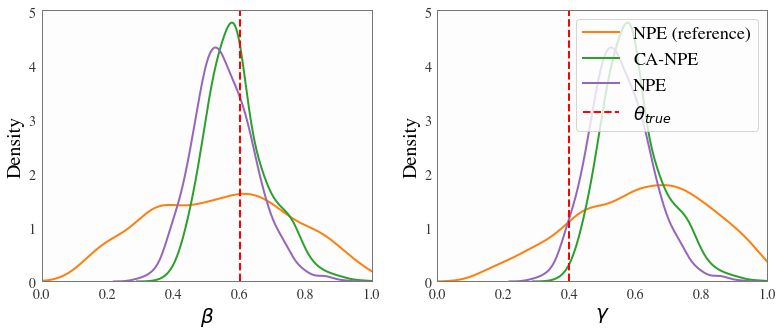

In [73]:
seed = 1
plt.figure(figsize=[13,5])
plt.subplot(1, 2, 1)
plt.xlim(0, 1)
sns.kdeplot(temp_sir_samples_npe_large[:,0], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,0], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=temp_sir_obs_theta.detach().numpy()[0], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')

plt.xlabel("$\\beta$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
# plt.title(f"MMD:{mmd[seed]:.2f}")

plt.subplot(1, 2, 2)
plt.xlim(0, 1)
sns.kdeplot(temp_sir_samples_npe_large[:,1], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,0], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=temp_sir_obs_theta.detach().numpy()[1], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.legend(fontsize=18, loc=1)
plt.xlabel("$\\gamma$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.show()

In [158]:
temp_sir_obs_x.shape

In [170]:
temp_sir_post_npe_large.log_prob(theta=temp_sir_post_reference[1:3].reshape(2,2), x=temp_sir_obs_x.reshape(1, -1))

# Figure 1

In [39]:
N = 20
n_rep = 50

beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)

beta_grid, gamma_grid = np.meshgrid(beta_range, gamma_range)
theta_grid = np.hstack((beta_grid.reshape(-1, 1), gamma_grid.reshape(-1, 1)))

cost_real = np.zeros([N, N])

In [179]:
for i in range(N):
    for j in range(N):
        st = time.time()
        for _ in range(n_rep):
            result = temp_sir(torch.tensor([beta_range[i], gamma_range[j]]))
        et = time.time()
        cost_real[i, j] = (et - st) / n_rep
    print(i)

In [40]:
cost_real = np.load("data/temporal_sir_cost_fig1.npy")

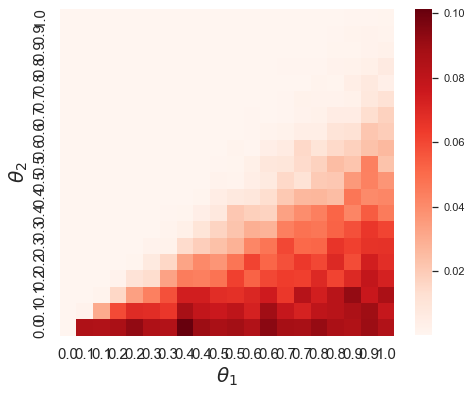

In [41]:
beta_range = np.linspace(0, 1, N)
gamma_range = np.linspace(0, 1, N)
sns.set(style="white")

plt.figure(figsize=(7.5, 6))
sns.heatmap(cost_real.T, xticklabels=np.round(beta_range, 1), yticklabels=np.round(gamma_range, 1), annot=False, fmt=".2f", cmap='Reds').invert_yaxis()
# plt.title('Cost Heatmap by $\\beta$ and $\\gamma$', size=25)
plt.xlabel('$\\theta_1$', size=20)
plt.ylabel('$\\theta_2$', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()